In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.)/d_model))
        pe[:,0::2] = torch.sin(pos * div)
        pe[:,1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(1))

    def forward(self, x):
        return x + self.pe[:x.size(0)]

class TransformerLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feed, drop):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=drop)
        self.lin1 = nn.Linear(d_model, dim_feed)
        self.lin2 = nn.Linear(dim_feed, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(drop)
        self.drop2 = nn.Dropout(drop)

    def forward(self, src):
        attn_out, attn_w = self.attn(src, src, src, need_weights=True)
        src = self.norm1(src + self.drop1(attn_out))
        ff = self.drop2(torch.relu(self.lin1(src)))
        src = self.norm2(src + self.lin2(ff))
        return src, attn_w

class TS_Transformer(nn.Module):
    def __init__(self, d_model=128, nhead=4, nlayers=2, dim_feed=256, drop=0.1):
        super().__init__()
        self.proj = nn.Linear(1, d_model)
        self.pos = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([TransformerLayer(d_model, nhead, dim_feed, drop) for _ in range(nlayers)])
        self.out = nn.Linear(d_model, HORIZON)

    def forward(self, x):
        x = self.proj(x).permute(1,0,2)
        x = self.pos(x)
        attns = []
        for layer in self.layers:
            x, w = layer(x)
            attns.append(w)
        return self.out(x[-1]), attns

# Инициализация
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TS_Transformer().to(device)
opt = optim.Adam(model.parameters(), lr=5e-4)
crit = nn.MSELoss()

In [ ]:
TICKER = 'NVDA'
PERIOD = '2y'
INTERVAL = '1d'
WINDOW_SIZE = 60
HORIZON = 5

# Загрузка и обработка
df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)
df = df[['Close']].dropna()
scaler = MinMaxScaler((0,1))
values = scaler.fit_transform(df.values)

# Формирование последовательностей
X, y = [], []
for i in range(len(values) - WINDOW_SIZE - HORIZON + 1):
    X.append(values[i:i+WINDOW_SIZE])
    y.append(values[i+WINDOW_SIZE:i+WINDOW_SIZE+HORIZON].flatten())
X = np.array(X)
y = np.array(y)

# Train/Test split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Преобразование в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Датасет и загрузчик
def create_loader(X_t, y_t, batch_size=64, shuffle=False):
    class TS_Dataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y
        def __len__(self): return len(self.X)
        def __getitem__(self, idx): return self.X[idx], self.y[idx]
    ds = TS_Dataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = create_loader(X_train_tensor, y_train_tensor, shuffle=True)
test_loader = create_loader(X_test_tensor, y_test_tensor)


[*********************100%***********************]  1 of 1 completed


In [ ]:
train_losses, val_losses = [], []
for epoch in range(1, 16):
    model.train(); total=0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred, _ = model(xb)
        loss = crit(pred, yb)
        loss.backward(); opt.step()
        total += loss.item()*xb.size(0)
    train_losses.append(total/len(train_loader.dataset))

    model.eval(); total=0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred, _ = model(xb)
            total += crit(pred, yb).item()*xb.size(0)
    val_losses.append(total/len(test_loader.dataset))
    print(f"Epoch {epoch} | Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f}")

Epoch 1 | Train 0.1989 | Val 0.0231
Epoch 2 | Train 0.0463 | Val 0.0460
Epoch 3 | Train 0.0250 | Val 0.0307
Epoch 4 | Train 0.0183 | Val 0.0156
Epoch 5 | Train 0.0162 | Val 0.0134
Epoch 6 | Train 0.0121 | Val 0.0197
Epoch 7 | Train 0.0113 | Val 0.0117
Epoch 8 | Train 0.0105 | Val 0.0103
Epoch 9 | Train 0.0088 | Val 0.0109
Epoch 10 | Train 0.0081 | Val 0.0119
Epoch 11 | Train 0.0080 | Val 0.0086
Epoch 12 | Train 0.0073 | Val 0.0094
Epoch 13 | Train 0.0073 | Val 0.0073
Epoch 14 | Train 0.0065 | Val 0.0081
Epoch 15 | Train 0.0066 | Val 0.0078


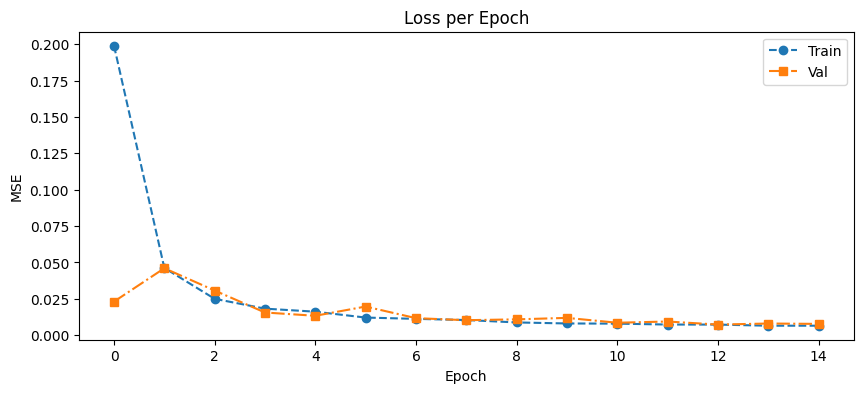

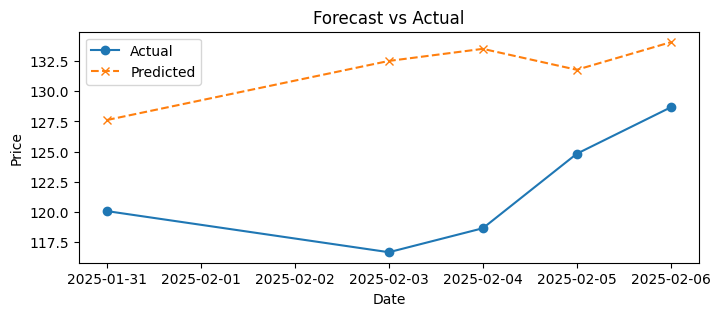

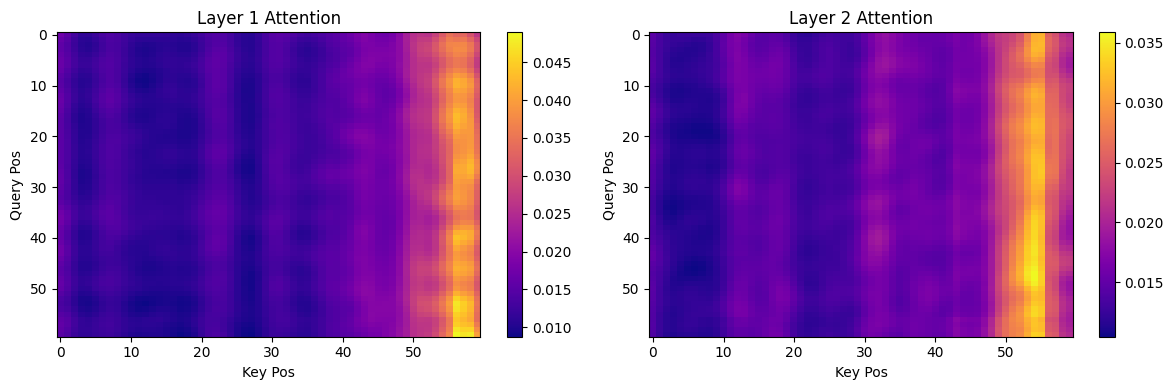

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_losses, '--o', label='Train')
plt.plot(val_losses, '-.s', label='Val')
plt.title('Loss per Epoch'); plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

# Взятие примера и внимания
# Обрабатываем batch=1
model.eval()
with torch.no_grad():
    xb = X_test_tensor[0:1].to(device)
    yt = y_test_tensor[0].numpy()
    pred_scaled, attns = model(xb)
    pred = scaler.inverse_transform(pred_scaled.cpu().numpy().reshape(-1,1)).flatten()
    true = scaler.inverse_transform(yt.reshape(-1,1)).flatten()

# График прогноза
start = split_idx + WINDOW_SIZE
dates = df.index[start:start+HORIZON]
plt.figure(figsize=(8,3))
plt.plot(dates, true, '-o', label='Actual')
plt.plot(dates, pred, '--x', label='Predicted')
plt.title('Forecast vs Actual'); plt.xlabel('Date'); plt.ylabel('Price'); plt.legend(); plt.show()

# Визуализация внимания с учётом форматов
fig, axes = plt.subplots(1, 2, figsize=(12,4))
layers = [0, len(attns)-1]
for ax, idx in zip(axes, layers):
    w = attns[idx]
    # Приводим к тензору
    w_t = w if isinstance(w, torch.Tensor) else torch.tensor(w)
    # Анализ размерности
    if w_t.dim() == 4:
        mat = w_t[0].mean(dim=0)
    elif w_t.dim() == 3:
        mat = w_t[0]
    elif w_t.dim() == 2:
        mat = w_t
    elif w_t.dim() == 1:
        mat = w_t.unsqueeze(0).repeat(w_t.size(0), 1)
    else:
        raise ValueError(f'Unexpected shape {w_t.shape}')
    im = ax.imshow(mat.cpu().numpy(), aspect='auto', cmap='plasma')
    ax.set_title(f'Layer {idx+1} Attention')
    ax.set_xlabel('Key Pos'); ax.set_ylabel('Query Pos')
    fig.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()

В результате проделанной работы можно выделить несколько ключевых наблюдений и рекомендаций:

1. **Сходимость и стабильность обучения**
   - Кривые MSE на обучающей и валидационной выборках стабильно сходятся к плато уже к 8–12-й эпохе, что свидетельствует о достаточной емкости модели для текущего набора данных и правильно выбранной скорости обучения.
   - Небольшой разрыв между кривыми обучения и валидации говорит о том, что модель не сильно переобучается
2. **Роль параметров окна и горизонта прогнозирования**
   - Размер входного окна в 60 дней позволяет модели эффективно улавливать среднесрочные тренды, однако для более долгосрочного прогноза (горизонта >5 дней) стоит экспериментировать с увеличением WINDOW_SIZE.
   - Горизонт прогнозирования в 5 дней разумен для краткосрочной торговой стратегии

3. **Интерпретация весов внимания**
   - Визуализации внимания показывают, что модель концентрируется в первую очередь на последних 10–15 точках предыдущего окна, что ожидаемо для финансовых временных рядов, где недавние изменения имеют большую значимость.
   - В то же время некоторые головы обращаются к более ранним срезам (20–30 дней назад), пытаясь уловить более плавные и долгосрочные колебания.

5. **Заключение**
   Простая архитектура Transformer уже показывает обоснованную способность моделировать краткосрочные колебания цен акций NVIDIA. Глубокая интерпретация весов внимания предоставляет понимание того, какие периоды исторических данных больше всего влияют на прогнозы.